In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [62]:
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding, SimpleRNN, LSTM, Dropout, RNN
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
import pandas as pd

df = pd.read_csv('bitcoin_20190307_per_day.csv')

In [4]:
df.shape

(3157, 7)

In [5]:
df['time'] = pd.to_datetime(df.time, unit='s')

In [6]:
df.isnull().sum()

close         0
high          0
low           0
open          0
time          0
volumefrom    0
volumeto      0
dtype: int64

In [7]:
df.head()

,close,high,low,open,time,volumefrom,volumeto
0,0.04951,0.04951,0.04951,0.04951,2010-07-17,20.00,0.9902
1,0.08584,0.08585,0.05941,0.04951,2010-07-18,75.01,5.0900
2,0.08080,0.09307,0.07723,0.08584,2010-07-19,574.00,49.6600
3,0.07474,0.08181,0.07426,0.08080,2010-07-20,262.00,20.5900
4,0.07921,0.07921,0.06634,0.07474,2010-07-21,575.00,42.2600


----

## RNN Data Processing 

In [8]:
df_time = df.set_index('time')

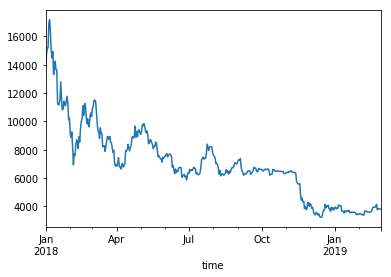

In [9]:
import matplotlib.pyplot as plt

df_time['close']['2018-01':'2019-02'].plot()
plt.show()

In [10]:
df_time.shape

(3157, 6)

In [11]:
# target: close
target = 'close'

In [12]:
shift_days = 1
shift_steps = shift_days * 30  # Number of days.

In [13]:
df_targets = df_time[target].shift(-shift_steps)

In [14]:
df_targets = df_targets[:len(df_targets)-30]

In [15]:
df_targets.shape

(3127,)

In [16]:
df_time.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600


In [17]:
X = df_time[:len(df_time)-30]

In [18]:
X.shape

(3127, 6)

In [19]:
x_data = X.values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (3097, 6)


In [20]:
y_data = df_targets.values[:-shift_steps]
y_data = y_data.reshape(-1, 1)
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (3097, 1)


In [21]:
num_data = len(x_data)
num_data

3097

In [22]:
train_split = 0.6

num_train = int(train_split * num_data)
num_train

1858

In [23]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

3097

In [24]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

3097

In [25]:
# input signals(feature)
num_x_signals = x_data.shape[1]
num_x_signals

6

In [26]:
# output dim
num_y_signals = y_data.shape[1]
num_y_signals

1

----

### Scaled Data

In [27]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 83244488.59


In [28]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [29]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [30]:
x_test_scaled = x_scaler.transform(x_test)

In [31]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

##  Data Generator

In [32]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [33]:
batch_size = 16

In [34]:
sequence_length = 30

In [35]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [36]:
x_batch, y_batch = next(generator)

In [37]:
print(x_batch.shape)
print(y_batch.shape)

(16, 30, 6)
(16, 30, 1)


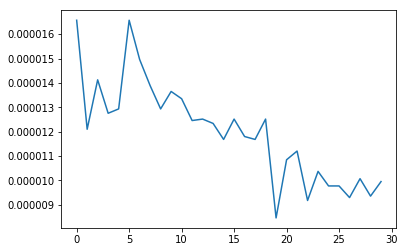

In [38]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

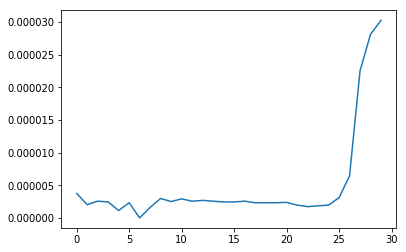

In [39]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

In [45]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

##  Create the Recurrent Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=64,
              return_sequences=True,
              input_shape=(None, num_x_signals)))
model.add(SimpleRNN(units=64,
              return_sequences=True))
model.add(Dense(16, activation='tanh'))
model.add(Dense(num_y_signals, activation='sigmoid'))


optimizer = RMSprop(lr=1e-3)
model.compile(loss='mse', optimizer=optimizer)

### Loss Function

In [ ]:
# warmup_steps = 50

# def loss_mse_warmup(y_true, y_pred):
#     """
#     Calculate the Mean Squared Error between y_true and y_pred,
#     but ignore the beginning "warmup" part of the sequences.
    
#     y_true is the desired output.
#     y_pred is the model's output.
#     """

#     # The shape of both input tensors are:
#     # [batch_size, sequence_length, num_y_signals].

#     # Ignore the "warmup" parts of the sequences
#     # by taking slices of the tensors.
#     y_true_slice = y_true[:, warmup_steps:, :]
#     y_pred_slice = y_pred[:, warmup_steps:, :]

#     # These sliced tensors both have this shape:
#     # [batch_size, sequence_length - warmup_steps, num_y_signals]

#     # Calculate the MSE loss for each value in these tensors.
#     # This outputs a 3-rank tensor of the same shape.
#     loss = tf.losses.mean_squared_error(labels=y_true_slice,
#                                         predictions=y_pred_slice)

#     # Keras may reduce this across the first axis (the batch)
#     # but the semantics are unclear, so to be sure we use
#     # the loss across the entire tensor, we reduce it to a
#     # single scalar with the mean function.
#     loss_mean = tf.reduce_mean(loss)

#     return loss_mean

In [ ]:
model.summary()

### Callback Functions

In [ ]:
# callback_early_stopping = EarlyStopping(monitor='val_loss',
#                                         patience=5, verbose=1)

In [ ]:
# callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                                        factor=0.1,
#                                        min_lr=1e-4,
#                                        patience=0,
#                                        verbose=1)

In [ ]:
# callbacks = [callback_early_stopping,
#              callback_reduce_lr]

##  Adjust Model

In [119]:
# model 1
model = Sequential()

model.add(LSTM(units=16,
              return_sequences=True,
              input_shape=(None, num_x_signals)))
model.add(SimpleRNN(units=16,
              return_sequences=True, 
              recurrent_dropout=0.01))
# model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_y_signals, activation='sigmoid'))


optimizer = Adam(lr=0.003)
model.compile(loss='mse', optimizer=optimizer)

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, None, 16)          1472      
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, None, 16)          528       
_________________________________________________________________
dense_55 (Dense)             (None, None, 16)          272       
_________________________________________________________________
dense_56 (Dense)             (None, None, 8)           136       
_________________________________________________________________
dense_57 (Dense)             (None, None, 1)           9         
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________


##  Train the Recurrent Neural Network

In [121]:
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=180,
#                     validation_data=validation_data,
                   )
#                     callbacks=callbacks)

Epoch 1/30
180/180 [==============================] - 6s 31ms/step - loss: 0.0252
Epoch 2/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0091
Epoch 3/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0084
Epoch 4/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0069
Epoch 5/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0067
Epoch 6/30
180/180 [==============================] - 2s 12ms/step - loss: 0.0067
Epoch 7/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0043
Epoch 8/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0037
Epoch 9/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0035
Epoch 10/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0037
Epoch 11/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0049
Epoch 12/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0037
Epoch 13/30
1

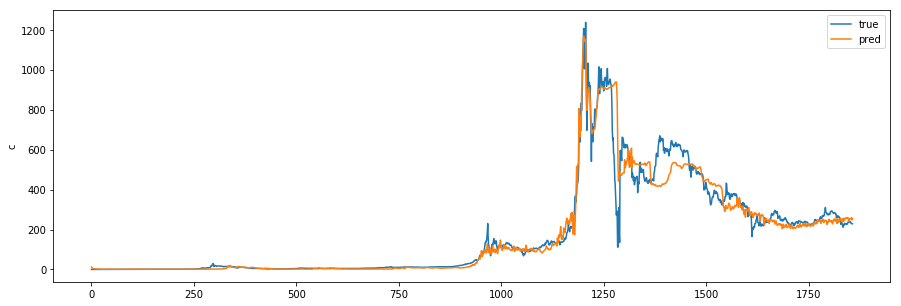

IndexError: index 1 is out of bounds for axis 1 with size 1

In [122]:
plot_comparison(start_idx=0, length=3000, train=True)

In [50]:
target_names = 'close'

In [48]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()